In [1]:
import networkx as nx
import random
import numpy as np

In [2]:
n = 9

In [3]:
G = nx.complete_graph(n, nx.DiGraph())
for (u,v) in G.edges:
    G.edges[u,v]['weight'] = random.random()

### Approximating PathMaxATSP via matching

In [4]:
Gu = nx.complete_graph(n)
for (u,v) in Gu.edges:
    w1 = G.edges[u,v]['weight']
    w2 = G.edges[v,u]['weight']
    Gu.edges[u,v]['weight'] = max(w1, w2)

In [5]:
matchings = nx.max_weight_matching(Gu)
print(matchings)

{(0, 1), (2, 3), (5, 6), (4, 7)}


In [6]:
dir_matchings = []
for (u,v) in matchings:
    if G.edges[u,v]['weight'] > G.edges[v,u]['weight']:
        dir_matchings.append((u,v))
    else:
        dir_matchings.append((v,u))
print(dir_matchings)

[(0, 1), (2, 3), (6, 5), (7, 4)]


In [7]:
def draw_edge_set(Gu, edges):
    colors = []
    for (u,v) in Gu.edges:
        if (u,v) in edges or (v,u) in edges:
            colors.append("red")
        else:
            colors.append("black")

    nx.draw_networkx(Gu, edge_color=colors)

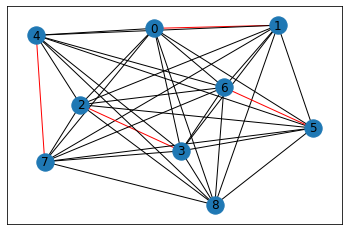

In [8]:
draw_edge_set(Gu, dir_matchings)

In [9]:
path = []
for (u,v) in dir_matchings:
    path.append(u)
    path.append(v)
print(path)

[0, 1, 2, 3, 6, 5, 7, 4]


In [10]:
if n % 2 == 1:
    vertex_sum = n * (n-1) / 2
    final_v = int(vertex_sum - sum(path))
    path.append(final_v)
    print(path)

[0, 1, 2, 3, 6, 5, 7, 4, 8]


In [11]:
def get_path_weight(path):
    total_weight = 0
    for u,v in zip(path, path[1:]):
        total_weight += G.edges[u,v]['weight']
    return total_weight

In [12]:
print(get_path_weight(path))

4.810471891263033


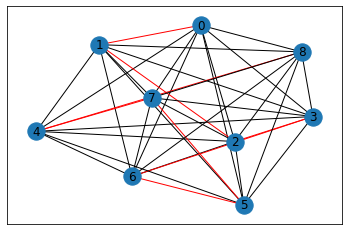

In [13]:
draw_edge_set(Gu, list(zip(path, path[1:])))

### Approximating PathMaxATSP via cycle cover

In [14]:
# TODO